In [1]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import zipfile
import io
import pandas as pd
import math
from IPython.display import display
from collections import defaultdict

zipped_data_path = "../data/clean_data/class-competition-cleaned.zip"

dataframes = defaultdict(pd.DataFrame)
with zipfile.ZipFile(zipped_data_path, "r") as zipf:
    for filename in zipf.namelist():
        if filename.endswith(".csv"):
            with zipf.open(filename) as f:
                dataframes.update({ filename : pd.read_csv(io.TextIOWrapper(f)) })

                # Lets take a look at the files
                print(f"FILE: {filename}")
                # If you want to see file info uncomment this:
                # display(dataframes[filename].info())
                # display(dataframes[filename].head())

FILE: train_call_type_A.csv
FILE: train_call_type_B.csv
FILE: train_call_type_C.csv
FILE: test_public.csv


In [2]:
train_data = dataframes["train_call_type_A.csv"]
test_data  = dataframes["test_public.csv"]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
train_data.head()

cuda:0


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,POLYLINE,TRAVEL_TIME,START_LOCATION,MON_sin,MON_cos,DAY_sin,DAY_cos,HR_sin,HR_cos,WK_sin,WK_cos,YR_2013
0,1372637343620000571,A,31508.0,NaN,20000571,"[[-8.618868,41.155101],[-8.6175,41.154912],[-8...",465,NaN,1.224647e-16,-1.0,-0.201299,0.97953,-0.965926,-0.258819,-0.781831,0.62349,True
1,1372639135620000570,A,33180.0,NaN,20000570,"[[-8.666757,41.174055],[-8.666784,41.174064],[...",270,NaN,1.224647e-16,-1.0,-0.201299,0.97953,-0.965926,-0.258819,-0.781831,0.62349,True
2,1372637254620000657,A,39233.0,NaN,20000657,"[[-8.660646,41.168574],[-8.661087,41.167926],[...",630,NaN,1.224647e-16,-1.0,-0.201299,0.97953,-0.965926,-0.258819,-0.781831,0.62349,True
3,1372637658620000596,A,22864.0,NaN,20000596,"[[-8.665686,41.170626],[-8.665677,41.170653],[...",375,NaN,1.224647e-16,-1.0,-0.201299,0.97953,-0.965926,-0.258819,-0.781831,0.62349,True
4,1372639535620000161,A,25862.0,NaN,20000161,"[[-8.648226,41.148333],[-8.648514,41.148297],[...",840,NaN,1.224647e-16,-1.0,-0.201299,0.97953,-0.965926,-0.258819,-0.781831,0.62349,True


In [3]:
# Use only data points with CALL_TYPE A
test_data = test_data[test_data['CALL_TYPE'] == 'A']
test_data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,START_LOCATION,MON_sin,MON_cos,DAY_sin,DAY_cos,HR_sin,HR_cos,WK_sin,WK_cos,YR_2013
5,T6,A,42612.0,NaN,20000607,NaN,-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,0.433884,-0.900969,False
7,T8,A,31780.0,NaN,20000619,NaN,-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,0.433884,-0.900969,False
21,T22,A,85698.0,NaN,20000199,NaN,-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,0.433884,-0.900969,False
22,T23,A,37007.0,NaN,20000480,NaN,-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,0.433884,-0.900969,False
36,T37,A,2002.0,NaN,20000159,NaN,-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,0.433884,-0.900969,False


In [4]:
from sklearn.preprocessing import StandardScaler
mean_encoding_taxi = train_data.groupby('TAXI_ID')['TRAVEL_TIME'].mean().reset_index()
mean_encoding_call = train_data.groupby('ORIGIN_CALL')['TRAVEL_TIME'].mean().reset_index()

# Create a dictionary mapping 'TAXI_ID' to mean 'TRAVEL_TIME' value
mean_encoding_taxi_dict = dict(zip(mean_encoding_taxi['TAXI_ID'], mean_encoding_taxi['TRAVEL_TIME']))

# Create a dictionary mapping 'ORIGIN_CALL' to mean 'TRAVEL_TIME' value
mean_encoding_call_dict = dict(zip(mean_encoding_call['ORIGIN_CALL'], mean_encoding_call['TRAVEL_TIME']))

# Replace the 'TAXI_ID' values with mean target encoding values
train_data.loc[:, 'TAXI_ID_MEAN_ENC'] = train_data['TAXI_ID'].map(mean_encoding_taxi_dict)
test_data.loc[:, 'TAXI_ID_MEAN_ENC'] = test_data['TAXI_ID'].map(mean_encoding_taxi_dict)

# Replace the 'ORIGIN_CALL' values with mean target encoding values
train_data.loc[:, 'ORIGIN_CALL_MEAN_ENC'] = train_data['ORIGIN_CALL'].map(mean_encoding_call_dict)
test_data.loc[:, 'ORIGIN_CALL_MEAN_ENC'] = test_data['ORIGIN_CALL'].map(mean_encoding_call_dict)

overall_mean_enc = train_data['ORIGIN_CALL_MEAN_ENC'].mean()
test_data['ORIGIN_CALL_MEAN_ENC'].fillna(overall_mean_enc, inplace=True)

mean_taxi_enc_train = pd.DataFrame(train_data['TAXI_ID_MEAN_ENC'])
mean_taxi_enc_test = pd.DataFrame(test_data['TAXI_ID_MEAN_ENC'])
mean_call_enc_train = pd.DataFrame(train_data['ORIGIN_CALL_MEAN_ENC'])
mean_call_enc_test = pd.DataFrame(test_data['ORIGIN_CALL_MEAN_ENC'])

# Initialize StandardScaler and fit it on the mean encoding column
scaler = StandardScaler()
scaler.fit(mean_taxi_enc_train)

# Transform the mean encoding column using the fitted scaler
normalized_taxi_enc_train = scaler.transform(mean_taxi_enc_train)
normalized_taxi_enc_test = scaler.transform(mean_taxi_enc_test)

# Replace the original mean encoding column with the normalized values
train_data.loc[:, 'TAXI_ID_MEAN_ENC_NORMALIZED'] = normalized_taxi_enc_train
test_data.loc[:, 'TAXI_ID_MEAN_ENC_NORMALIZED'] = normalized_taxi_enc_test

# Initialize StandardScaler and fit it on the mean encoding column
scaler = StandardScaler()
scaler.fit(mean_call_enc_train)

# Transform the mean encoding column using the fitted scaler
normalized_call_enc_train = scaler.transform(mean_call_enc_train)
normalized_call_enc_test = scaler.transform(mean_call_enc_test)

# Replace the original mean encoding column with the normalized values
train_data.loc[:, 'ORIGIN_CALL_MEAN_ENC_NORMALIZED'] = normalized_call_enc_train
test_data.loc[:, 'ORIGIN_CALL_MEAN_ENC_NORMALIZED'] = normalized_call_enc_test

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346466 entries, 0 to 346465
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   TRIP_ID                          346466 non-null  int64  
 1   CALL_TYPE                        346466 non-null  object 
 2   ORIGIN_CALL                      346466 non-null  float64
 3   ORIGIN_STAND                     0 non-null       float64
 4   TAXI_ID                          346466 non-null  int64  
 5   POLYLINE                         346466 non-null  object 
 6   TRAVEL_TIME                      346466 non-null  int64  
 7   START_LOCATION                   0 non-null       float64
 8   MON_sin                          346466 non-null  float64
 9   MON_cos                          346466 non-null  float64
 10  DAY_sin                          346466 non-null  float64
 11  DAY_cos                          346466 non-null  float64
 12  HR

C:\Users\Tyler Holston\AppData\Local\Temp\ipykernel_27540\1169247368.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'TAXI_ID_MEAN_ENC'] = test_data['TAXI_ID'].map(mean_encoding_taxi_dict)
C:\Users\Tyler Holston\AppData\Local\Temp\ipykernel_27540\1169247368.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'ORIGIN_CALL_MEAN_ENC'] = test_data['ORIGIN_CALL'].map(mean_encoding_call_dict)
C:\Users\Tyler Holston\AppData\Local\Temp\ipykernel_27540\1169247368.py:20: Settin

In [6]:
from sklearn.model_selection import train_test_split

# We could totally change this. Utilization of these just probably requires further preprocessing.
ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION = ['TRIP_ID', 'CALL_TYPE', 'ORIGIN_STAND', 'POLYLINE', 'START_LOCATION', 'ORIGIN_CALL', 'TAXI_ID', 'ORIGIN_CALL_MEAN_ENC', 'TAXI_ID_MEAN_ENC']

train_data_sample = train_data.sample(frac=0.8, random_state=420) # frac is used to control percentage of train data used
X = train_data_sample.drop("TRAVEL_TIME", axis=1)
X = X.loc[:, ~X.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]
y = train_data_sample["TRAVEL_TIME"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

test_features = test_data.loc[:, ~test_data.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]

In [7]:
from torch.utils.data import DataLoader, Dataset
from mlp_utils import TaxiDataset
    
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_test_public = test_features.astype(float) # This is what we can predict on

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)
X_test_public_tensor = torch.tensor(X_test_public.values, dtype=torch.float32)

train_dataset = TaxiDataset(X_train_tensor, y_train_tensor)
test_dataset = TaxiDataset(X_test_tensor, y_test_tensor)
test_public_dataset = TaxiDataset(X_test_public_tensor)

batch_size = 32

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataloader_pred = DataLoader(test_public_dataset, batch_size=batch_size)

In [8]:
import torch.nn.functional as F

def init_weights(m):
  if isinstance(m, nn.Linear):
    nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(11, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, 256)
    self.fc4 = nn.Linear(256, 128)
    self.fc5 = nn.Linear(128, 64)
    self.fc6 = nn.Linear(64, 1)
    self.apply(init_weights)
    self.apply(init_weights)

  def forward(self, x):
    '''
      Forward pass
    '''
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = self.fc6(x)
    return x

In [9]:
from mlp_utils import num_parameters

mlp = MLP()
if torch.cuda.is_available():
    mlp.cuda()
 
num_parameters(mlp)

175873

In [10]:
from mlp_utils import pipeline
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001, weight_decay=1e-2)

train_losses, test_loss, predictions = pipeline(mlp, optimizer, dataloader_train=dataloader_train, 
                                                dataloader_test=dataloader_test, dataloader_pred=dataloader_pred,
                        			device=device, criterion=criterion, epochs=10)

100%|██████████| 10/10 [03:07<00:00, 18.70s/it]


Training process has finished.


In [11]:
print(f"Final Train Loss: {train_losses[-1]}")
print(f"Test Loss: {test_loss}")

Final Train Loss: 315.3367693648248
Test Loss: 316.5821367018478


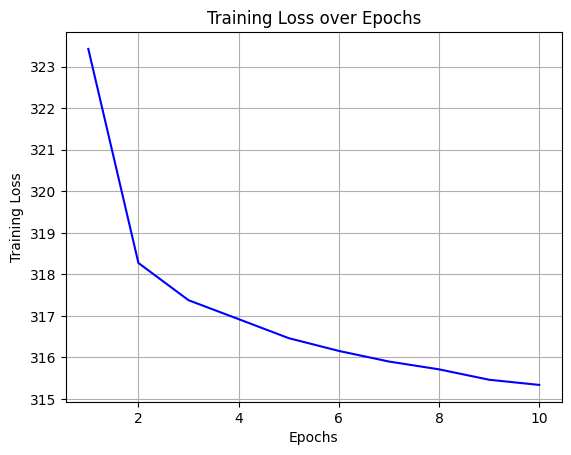

[323.4290198795421, 318.2737961488016, 317.3769667054324, 316.9211996542803, 316.46297332792994, 316.15555371707296, 315.90012047599447, 315.71194031939353, 315.4613653420694, 315.3367693648248]


In [13]:
import matplotlib.pyplot as plt

# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot the training loss
plt.plot(epochs, train_losses, 'b-')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

print(train_losses)

In [12]:
from mlp_utils import test_prediction_to_csv

test_prediction_to_csv(predictions, "predicting_six_layer_mlp_call_type_a.csv", test_data)